In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df=pd.read_csv("Online Sales Data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    240 non-null    int64         
 1   Date              240 non-null    datetime64[ns]
 2   Product Category  240 non-null    object        
 3   Product Name      240 non-null    object        
 4   Units Sold        240 non-null    int64         
 5   Unit Price        240 non-null    float64       
 6   Total Revenue     240 non-null    float64       
 7   Region            240 non-null    object        
 8   Payment Method    240 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 17.0+ KB


In [4]:
df.rename(columns={"Total Revenue":"Total_Revenue", "Units Sold" : "Units_Sold","Unit Price" : "Unit_Price"},inplace = True)

## Preprocessing

In [5]:
def encode_dates(df,column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column])
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df = df.drop(column, axis=1)
    return df

In [6]:
def preprocess_inputs(df):
    df = df.copy()
    #Drop unnecessary columns
    df = df.drop(['Transaction ID','Region','Payment Method','Product Name', 'Product Category'],axis = 1)
    df = encode_dates(df, column = 'Date')

    #Split df into X and y
    y = df['Total_Revenue']
    X = df.drop('Total_Revenue', axis =1 )
    #Train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = False, random_state = 1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

    return X_train, X_test, y_train, y_test
    


 

In [7]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [8]:
X_train

,Units_Sold,Unit_Price,Date_year,Date_month,Date_day
0,-0.208863,1.610443,0.0,-1.421380,-1.604506
1,-0.910644,0.534403,0.0,-1.421380,-1.490093
2,0.492918,-0.390991,0.0,-1.421380,-1.375680
3,1.194699,-0.507203,0.0,-1.421380,-1.261267
4,-0.910644,-0.347949,0.0,-1.421380,-1.146854
...,...,...,...,...,...
163,-0.910644,-0.111221,0.0,1.679813,-0.345963
164,1.896480,-0.477074,0.0,1.679813,-0.231550
165,1.194699,-0.522268,0.0,1.679813,-0.117137
166,-0.910644,-0.505051,0.0,1.679813,-0.002724


In [9]:
X_train.describe()

,Units_Sold,Unit_Price,Date_year,Date_month,Date_day
count,1.680000e+02,1.680000e+02,168.0,168.000000,1.680000e+02
mean,7.401487e-17,9.251859e-17,0.0,0.000000,5.286776e-18
std,1.002990e+00,1.002990e+00,0.0,1.002990,1.002990e+00
min,-9.106445e-01,-5.276265e-01,0.0,-1.421380,-1.604506e+00
25%,-9.106445e-01,-4.770741e-01,0.0,-0.801142,-8.322181e-01
50%,-2.088634e-01,-3.479494e-01,0.0,-0.180903,-5.993060e-02
75%,4.929177e-01,2.326283e-02,0.0,1.059575,8.267699e-01
max,5.405385e+00,7.851473e+00,0.0,1.679813,1.827883e+00


In [10]:
X_train.shape

(168, 5)

## Training

In [11]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(200, activation ='relu')(inputs)
x = tf.keras.layers.Dense(200, activation ='relu')(x)

#Predicted Price
outputs = tf.keras.layers.Dense(1, activation = 'linear')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,601 (162.50 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'mse'
)

history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True

        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 541160.5000 - val_loss: 177094.9531 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 589325.4375 - val_loss: 176592.4062 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 548399.8750 - val_loss: 176023.5312 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 501726.7500 - val_loss: 175330.0469 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 425397.8750 - val_loss: 174502.4688 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 506333.5000 - val_loss: 173472.9219 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 607356.3125 - val_loss: 172266.5000 - learning_rate: 0.0010
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 404062.9688 - val_loss: 170915.1094 - learning_rate: 0.0010
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 53313

## Results

In [13]:

test_loss = model.evaluate(X_test, y_test,verbose = 0)

print("Test Loss: {:.5f}".format(test_loss))

Test Loss: 13062.97754


In [14]:
#Test R2 determines how accurate the model is to the dataset
y_pred = np.squeeze(model.predict(X_test))

test_r2 = r2_score(y_test,y_pred)

print("Test R^2 Score: {:.5f}".format(test_r2))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test R^2 Score: 0.87232


In [15]:
y_pred2 = model.predict(X_test)
y_pred2

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


array([[ 695.8752 ],
       [ 213.24542],
       [ 180.79997],
       [ 155.5938 ],
       [ 159.86891],
       [ 697.42694],
       [ 212.00874],
       [ 198.22575],
       [ 232.4517 ],
       [ 214.21057],
       [ 211.87183],
       [ 259.4071 ],
       [ 663.358  ],
       [ 446.98694],
       [ 189.3321 ],
       [ 149.16762],
       [ 241.36588],
       [ 496.30597],
       [ 399.90024],
       [ 253.69157],
       [ 196.27762],
       [ 160.73648],
       [ 147.23468],
       [ 224.6843 ],
       [ 244.59332],
       [ 245.58778],
       [ 246.16203],
       [ 159.48692],
       [ 208.47446],
       [ 437.24942],
       [ 257.79764],
       [ 205.90196],
       [ 221.38129],
       [ 186.48172],
       [ 197.36589],
       [ 414.09454],
       [ 345.7064 ],
       [ 407.21826],
       [ 254.63959],
       [ 242.67534],
       [ 244.84035],
       [ 274.32404],
       [ 746.0076 ],
       [ 325.1759 ],
       [ 294.25348],
       [ 183.05777],
       [ 178.46432],
       [ 368.

In [16]:
df2 = pd.DataFrame(data = {"Actual Values ": y_test,
                           "Predicted Values: ": y_pred})
df2

,Actual Values,Predicted Values:
168,699.99,695.875183
169,279.98,213.245422
170,104.97,180.799973
171,19.98,155.593796
172,29.50,159.868912
...,...,...
235,159.99,289.038483
236,270.00,292.363739
237,32.97,261.270569
238,55.00,256.130768


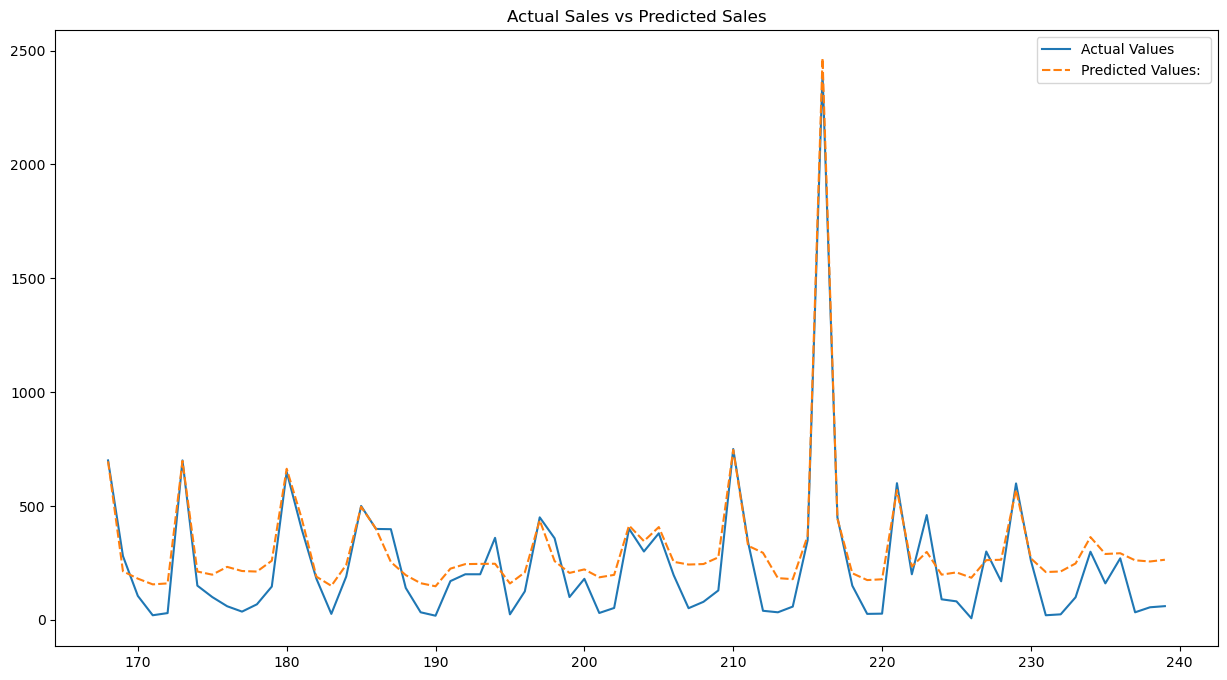

In [17]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df2)
plt.title("Actual Sales vs Predicted Sales")
plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    240 non-null    int64         
 1   Date              240 non-null    datetime64[ns]
 2   Product Category  240 non-null    object        
 3   Product Name      240 non-null    object        
 4   Units_Sold        240 non-null    int64         
 5   Unit_Price        240 non-null    float64       
 6   Total_Revenue     240 non-null    float64       
 7   Region            240 non-null    object        
 8   Payment Method    240 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 17.0+ KB


In [19]:
future_dates = pd.date_range('2024-09-01', end='2024-12-31',freq='MS')

In [34]:
future_data = pd.DataFrame({
    'date': future_dates,
    'previous_sales': [-1.66,-1.23,.93,-0.98],
    'Units_Sold' : [-.68,-1.73,0.23,.57]
})

In [43]:
X_test.head(30).mean()

Units_Sold   -0.349220
Unit_Price   -0.130348
Date_year     0.000000
Date_month    2.010607
Date_day      0.054482
dtype: float64

In [35]:
future_data['month'] = future_data['date'].dt.month
future_data['year'] = future_data['date'].dt.year
future_data['day'] = future_data['date'].dt.day

In [36]:
X_future = future_data.drop(columns=['date'])

In [37]:
future_sales_predictions = model.predict(X_future)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [38]:
future_data['predicted_sales'] = future_sales_predictions

In [39]:
print(future_data[['date','predicted_sales']])

        date  predicted_sales
0 2024-09-01    104652.367188
1 2024-10-01    104498.492188
2 2024-11-01    104833.570312
3 2024-12-01    104874.078125


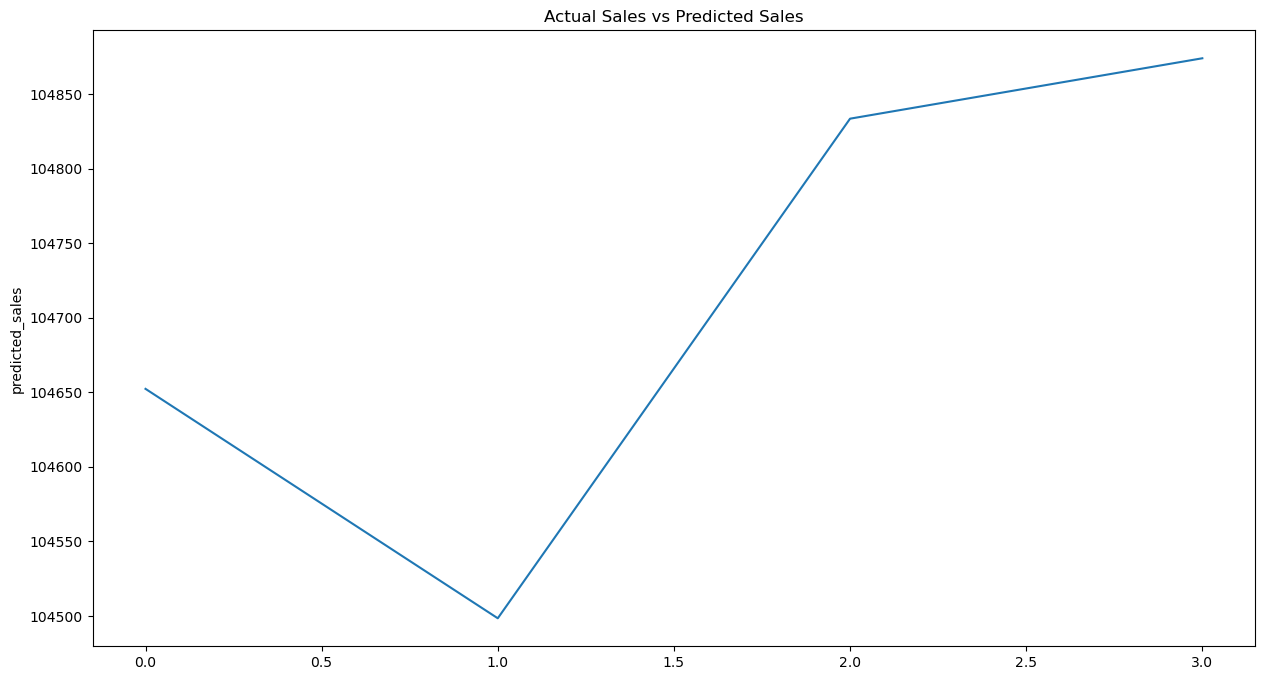

In [41]:
plt.figure(figsize=(15,8))
sns.lineplot(data=future_data['predicted_sales'])
plt.title("Actual Sales vs Predicted Sales")
plt.show()